<a href="https://colab.research.google.com/github/ChirathiSomadasa/Deep_Learning_Assignment/blob/Balasooriya-B.M.P.U/Deep_Learning_Assignment_IT22927248.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Plant Disease Classification**

##**Balasooriya B.M.P.U.  -  IT22927248**

### Transfer Leaning Specialist - Custom CNN

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import shutil
from google.colab import drive


In [3]:
# Mount Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Unzip the dataset

!unzip -q -o "/content/drive/MyDrive/DL/PlantVillage.zip" -d "/content/PlantVillage"

In [7]:
# Fix folder structure if nested

import os
import shutil

In [8]:
# Check if inner folder exists

inner_dir = "/content/PlantVillage/PlantVillage"
if os.path.exists(inner_dir):
    for folder in os.listdir(inner_dir):
        src = os.path.join(inner_dir, folder)
        dst = os.path.join("/content/PlantVillage", folder)
        shutil.move(src, dst)
    os.rmdir(inner_dir)

In [9]:
# Create smaller dataset for fast demo (optional)
original_dir = "/content/PlantVillage"
fast_dir = "/content/PlantVillage_FastDemo"
images_per_class = 200  # reduce per class for fast execution

if not os.path.exists(fast_dir):
    os.makedirs(fast_dir)

for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if os.path.isdir(class_path):
        fast_class_path = os.path.join(fast_dir, class_name)
        os.makedirs(fast_class_path, exist_ok=True)

        # Copy only image files (ignore subfolders)
        img_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        img_files = img_files[:images_per_class]  # limit per class

        for img in img_files:
            src = os.path.join(class_path, img)
            dst = os.path.join(fast_class_path, img)
            shutil.copy(src, dst)

In [10]:
# Use the fast demo directory for training

data_dir = fast_dir

In [11]:
# Data preprocessing and augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [12]:
# Create data generators

img_size = (128, 128)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2362 images belonging to 16 classes.
Found 590 images belonging to 16 classes.


In [13]:
# Get class names

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")

Training samples: 2362
Validation samples: 590
Number of classes: 16
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy', 'plantvillage']


In [23]:
# Design the custom CNN architecture with proper input specification

from tensorflow.keras.layers import Input

model = Sequential([
    # Input layer
    Input(shape=(128, 128, 3)),

    # First convolutional block
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Fourth convolutional block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer
    Dense(num_classes, activation='softmax')
])

In [24]:
# Compile the model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Display model architecture

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 5,247,952 (20.02 MB)

 Trainable params: 5,245,456 (20.01 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [26]:
# Define callbacks

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

In [28]:
# Replace the ImageDataGenerator approach with this:
# Create datasets

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Apply data augmentation to training dataset
def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.1)
    return image, label

# Apply augmentation only to training data
train_ds = train_ds.map(augment_images)
# Normalize both datasets
train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds = val_ds.map(lambda x, y: (x/255.0, y))

# Optimize performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2952 files belonging to 16 classes.
Using 2362 files for training.
Found 2952 files belonging to 16 classes.
Using 590 files for validation.


In [29]:
# Train the model with the new dataset approach

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.2217 - loss: 3.0229 - val_accuracy: 0.0593 - val_loss: 17.1437 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4949 - loss: 1.6874 - val_accuracy: 0.0593 - val_loss: 20.4765 - learning_rate: 0.0010
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5712 - loss: 1.3211 - val_accuracy: 0.0593 - val_loss: 16.0583 - learning_rate: 0.0010
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6184 - loss: 1.1936 - val_accuracy: 0.0593 - val_loss: 15.3544 - learning_rate: 0.0010
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6659 - loss: 0.9980 - val_accuracy: 0.0881 - val_loss: 11.2320 - learning_rate: 0.0010
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7095 - loss: 0.8828 - val_accuracy: 0.1237 - val_loss: 11.6457 - learning_rate: 0.0010
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7152 - loss: 0.8417 - v

In [30]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.6193 - loss: 1.9518
Test Accuracy: 62.20%


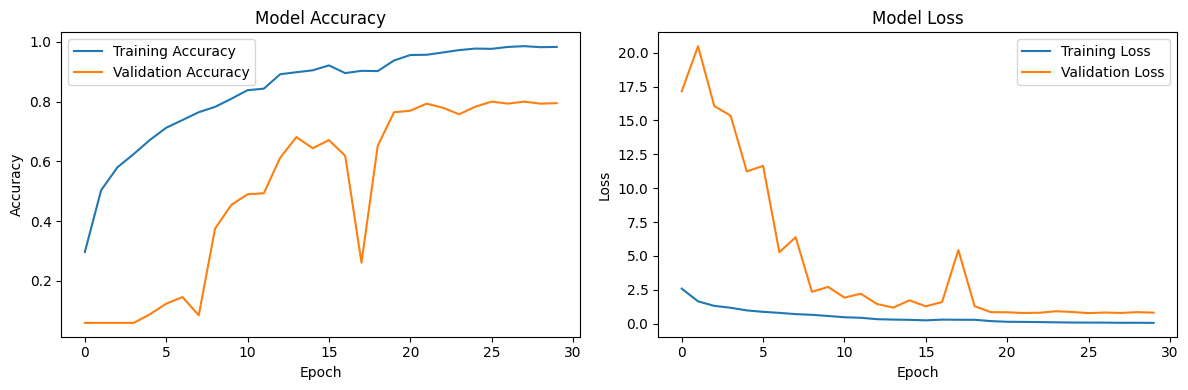

In [32]:
# Plot training history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Generate predictions

validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step


In [34]:
# Get true labels

true_classes = validation_generator.classes

In [36]:
# Remove any empty directories before creating generators

import os
data_dir = "/content/PlantVillage_FastDemo"

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        if len(os.listdir(class_path)) == 0:  # If folder is empty
            os.rmdir(class_path)
            print(f"Removed empty directory: {class_name}")

Removed empty directory: plantvillage


In [38]:
# generate the report

print(classification_report(true_classes, predicted_classes,
                           target_names=class_names,
                           zero_division=0))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.90      0.45      0.60        40
                     Pepper__bell___healthy       0.82      0.70      0.76        40
                      Potato___Early_blight       0.77      0.82      0.80        40
                       Potato___Late_blight       0.72      0.53      0.61        40
                           Potato___healthy       0.43      0.83      0.57        30
                      Tomato_Bacterial_spot       0.90      0.90      0.90        40
                        Tomato_Early_blight       0.89      0.40      0.55        40
                         Tomato_Late_blight       0.89      0.60      0.72        40
                           Tomato_Leaf_Mold       0.91      0.53      0.67        40
                  Tomato_Septoria_leaf_spot       0.88      0.53      0.66        40
Tomato_Spider_mites_Two_spotted_spider_mite       0.57      0.50

In [41]:
# Model save:

model.save('custom_cnn_plant_disease.keras')
print("Model saved as 'custom_cnn_plant_disease.keras'")

Model saved as 'custom_cnn_plant_disease.keras'


In [42]:
# Function to predict on new images

def predict_disease(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    return class_names[predicted_class], confidence

In [43]:
# Test the prediction function with a sample image_1

sample_image_path = "/content/PlantVillage/Tomato_Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Predicted Disease: Tomato_Bacterial_spot with confidence: 0.66


In [46]:
# Test the prediction function with a sample image_2

sample_image_path = "/content/PlantVillage/Tomato__Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG"

predicted_class, confidence = predict_disease(sample_image_path)
print(f"Predicted Disease: {predicted_class} with confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Disease: Tomato__Tomato_mosaic_virus with confidence: 1.00
